In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs

In [2]:
from anemoi.datasets import open_dataset
from anemoi.graphs.nodes.builders.from_reduced_gaussian import ReducedGaussianGridNodes
from anemoi.datasets.grids import cutout_mask
from anemoi.graphs.generate.utils import get_coordinates_ordering

In [3]:
plt.style.use("~/nice.mplstyle")

In [4]:
def open_nested(trim_edge=0, min_distance_km=0):
    
    data_dir = "/pscratch/sd/t/timothys/nested-eagle/0.25deg-06km/data"
    return open_dataset(
        cutout=[
            {
                "dataset": f"{data_dir}/hrrr.zarr",
                "trim_edge": trim_edge,
            },
            f"{data_dir}/gfs.zarr",
        ],
        adjust="all",
        min_distance_km=min_distance_km,
    )

In [5]:
data = open_nested(trim_edge=[25, 24, 25, 26], min_distance_km=6)
n_cutout = data.grids[0]
print(n_cutout)

Dataset /pscratch/sd/t/timothys/nested-eagle/0.25deg-06km/data/hrrr.zarr has missing dates
Dataset /pscratch/sd/t/timothys/nested-eagle/0.25deg-06km/data/gfs.zarr has missing dates


407040


In [6]:
gmesh = ReducedGaussianGridNodes(grid="o96", name="global").get_coordinates()
gmesh = np.rad2deg(np.asarray(gmesh))
hmesh = xr.load_dataset("../csmswt-trim25/latentx4.spongex1.hrrr06km.trim25-24.25-26.nc")

In [7]:
mask = cutout_mask(
    lats=hmesh.lat.values.flatten(),
    lons=hmesh.lon.values.flatten(),
    global_lats=gmesh[:, 0],
    global_lons=gmesh[:, 1],
    min_distance_km=2*6,
)

In [8]:
gcut = gmesh[mask]
hnest= np.stack([hmesh.lat.values.flatten(), hmesh.lon.values.flatten()], axis=-1)

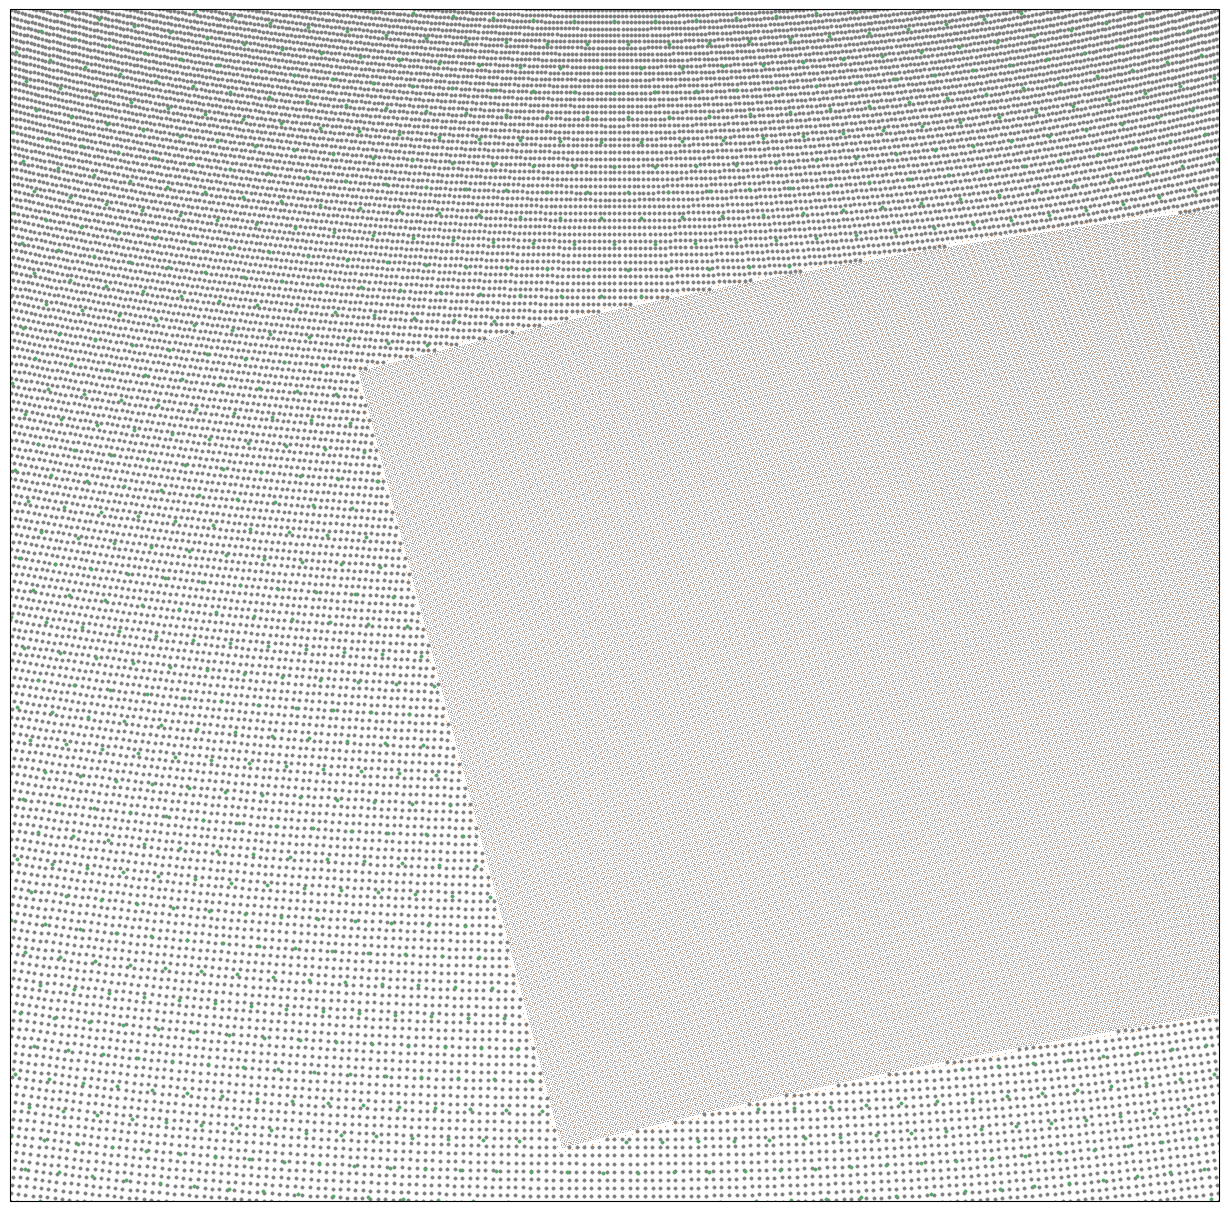

In [9]:
fig, ax = plt.subplots(
    1, 1,
    figsize=(16,12),
    subplot_kw={"projection": ccrs.Orthographic(central_longitude=-120, central_latitude=20)},
)

for x,y, x_d, y_d, s in zip(
    [gcut[:, 1], hnest[:, 1]],
    [gcut[:, 0], hnest[:, 0]],
    [data.longitudes[n_cutout:], data.longitudes[:n_cutout]],
    [data.latitudes[n_cutout:], data.latitudes[:n_cutout]],
    [6, .1],
):

    kw = {"transform": ccrs.PlateCarree(), "s": s}
    ax.scatter(x_d, y_d, color="gray", **kw)
    ax.scatter(x,y, **kw)
ax.set_extent([-140, -100, 20, 60], crs=ccrs.PlateCarree())

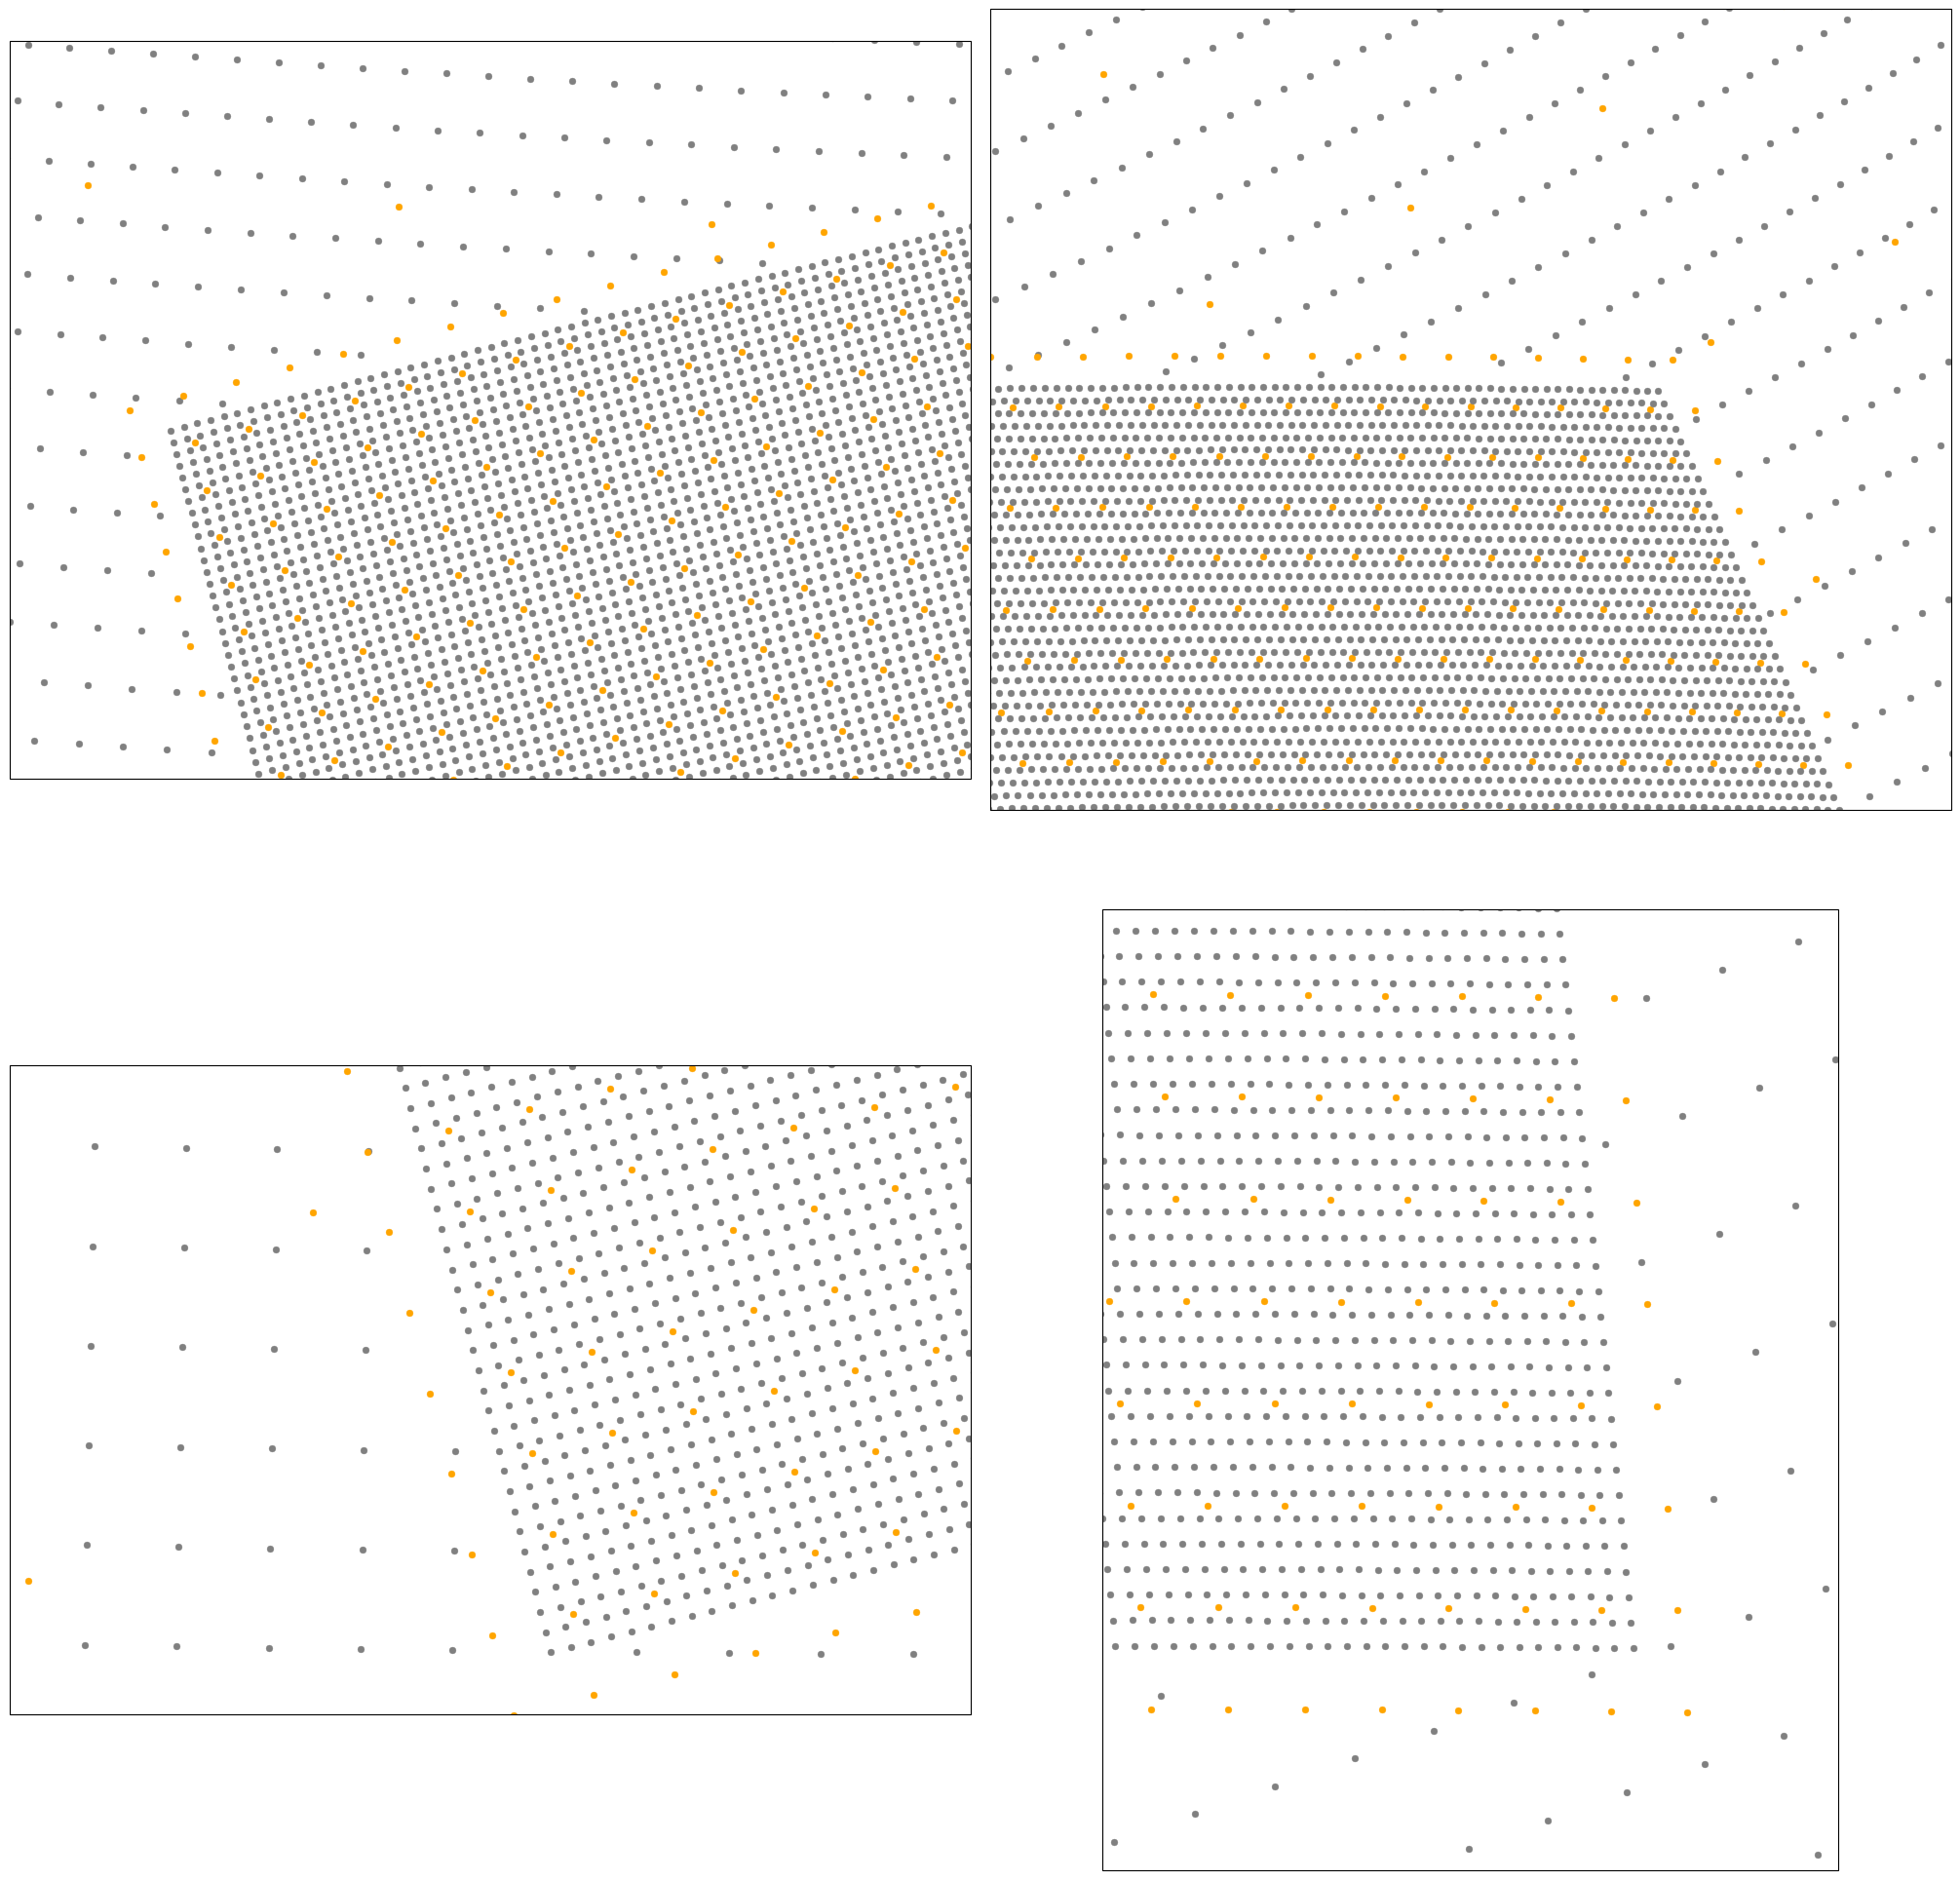

In [10]:
fig, axs = plt.subplots(
    2, 2,
    figsize=(20,20),
    subplot_kw={"projection": ccrs.Orthographic(central_longitude=-120, central_latitude=20)},
)

for x, y, x_d, y_d, s in zip(
    [gcut[:, 1], hnest[:, 1]],
    [gcut[:, 0], hnest[:, 0]],
    [data.longitudes[n_cutout:], data.longitudes[:n_cutout]],
    [data.latitudes[n_cutout:], data.latitudes[:n_cutout]],
    [24, 2*12],
):

    kw = {"transform": ccrs.PlateCarree(), "s": s}
    for ax in axs.flatten():
        ax.scatter(x,y, color="orange", **kw)
        ax.scatter(x_d, y_d, color="gray", **kw)
# The overview
#axs[0].set_extent([-140, -100, 20, 60], crs=ccrs.PlateCarree())
#axs[1].set_extent([-125, -115, 20, 30], crs=ccrs.PlateCarree())

axs[0, 0].set_extent([227.85, 232.85, 45.8, 48.8], crs=ccrs.PlateCarree())
#axs[0, 0].set_extent([180, 250.85, 30.2, 48.6], crs=ccrs.PlateCarree())
axs[0, 1].set_extent([292.6, 297.6, 46.2, 48.6], crs=ccrs.PlateCarree())
axs[1, 0].set_extent([236.8, 239.4, 22.6, 24.2], crs=ccrs.PlateCarree())
axs[1, 1].set_extent([285.6, 287.2, 22.55, 24.2], crs=ccrs.PlateCarree())
##fig.savefig(f"mesh_and_data_nodes.jpeg", bbox_inches="tight", dpi=300)

In [11]:
clon = np.concatenate([gcut[:, 1], hnest[:, 1]])
clat = np.concatenate([gcut[:, 0], hnest[:, 0]])
coords = np.stack([clat, clon], axis=-1)

In [12]:
len(coords)

65346

In [13]:
len(gmesh)

40320

In [14]:
len(gcut), len(hnest), len(coords)

(39238, 26108, 65346)

In [15]:
len(hnest) / len(coords)

0.3995347840724757

In [16]:
latlon = np.load("../csmswt-trim25/latentx4.spongex1.combined.sorted.npz")

In [17]:
n = len(latlon["lat"])
n-len(hnest), len(hnest), n

(63277, 26108, 89385)

In [18]:
print(n-len(hnest) - len(gcut))

24039


This uses ~24k fewer mesh nodes than the latlon version... cool.

In [19]:
coords = np.stack([clat, clon], axis=-1)
coords = np.deg2rad(coords)
order = get_coordinates_ordering(coords)
coords = np.rad2deg(coords[order])

In [20]:
cds = xr.Dataset(
    attrs={"n_cutout": n_cutout}
)

cds["lon"] = xr.DataArray(
    coords[:, 1],
    coords={"lon": coords[:, 1]},
)

cds["lat"] = xr.DataArray(
    coords[:, 0],
    coords={"lat": coords[:,0]},
)

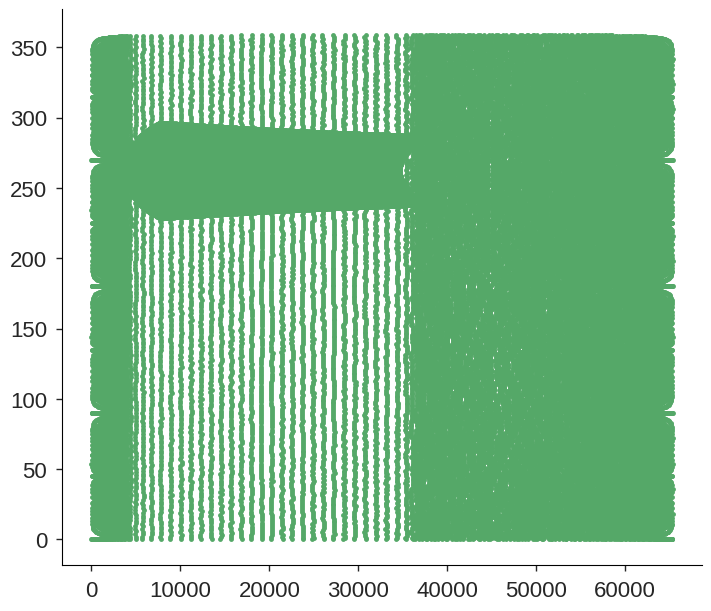

In [21]:
plt.plot(cds.lon.values, ls="", marker=".")

In [22]:
np.savez("latent.o96.spongex1.combined.sorted.npz", lon=cds.lon.values, lat=cds.lat.values)

In [23]:
np.sqrt(100**2 + 100**2)

141.4213562373095

In [24]:
np.sqrt(24**2 + 24**2)

33.94112549695428

In [25]:
28513 / 8

3564.125

In [26]:
len(coords) / 8

8168.25

In [27]:
cds.lat.where((cds.lat > 22) & (cds.lat < 53), drop=True)

<xarray.DataArray 'lat' (lat: 32946)> Size: 264kB
array([52.83091393, 52.83091393, 52.83091393, ..., 22.64290415,
       22.61170712, 22.58876052])
Coordinates:
  * lat      (lat) float64 264kB 52.83 52.83 52.83 52.83 ... 22.64 22.61 22.59

In [28]:
32946 / len(coords)

0.504177761454412

In [4]:
32946 / 8168

4.0335455435847205

In [7]:
18801 / 3564

5.275252525252525